# TCRpeg p infer distribution heatmap

In [1]:
# Add autoreload for easier development
%load_ext autoreload
%autoreload 2

In [2]:
from tcrpeg_toolkit.distribution_handler import DistributionHeatmapPlotter

In [4]:
plot_heatmap = DistributionHeatmapPlotter(data='results_sample_data/p_infer/raw/')

INFO - Loaded 2 distributions with their IDs
INFO - Jensen-Shannon divergence metric selected.


INFO - Loaded 2 files
/opt/miniconda3/envs/tcrpeg_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/miniconda3/envs/tcrpeg_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


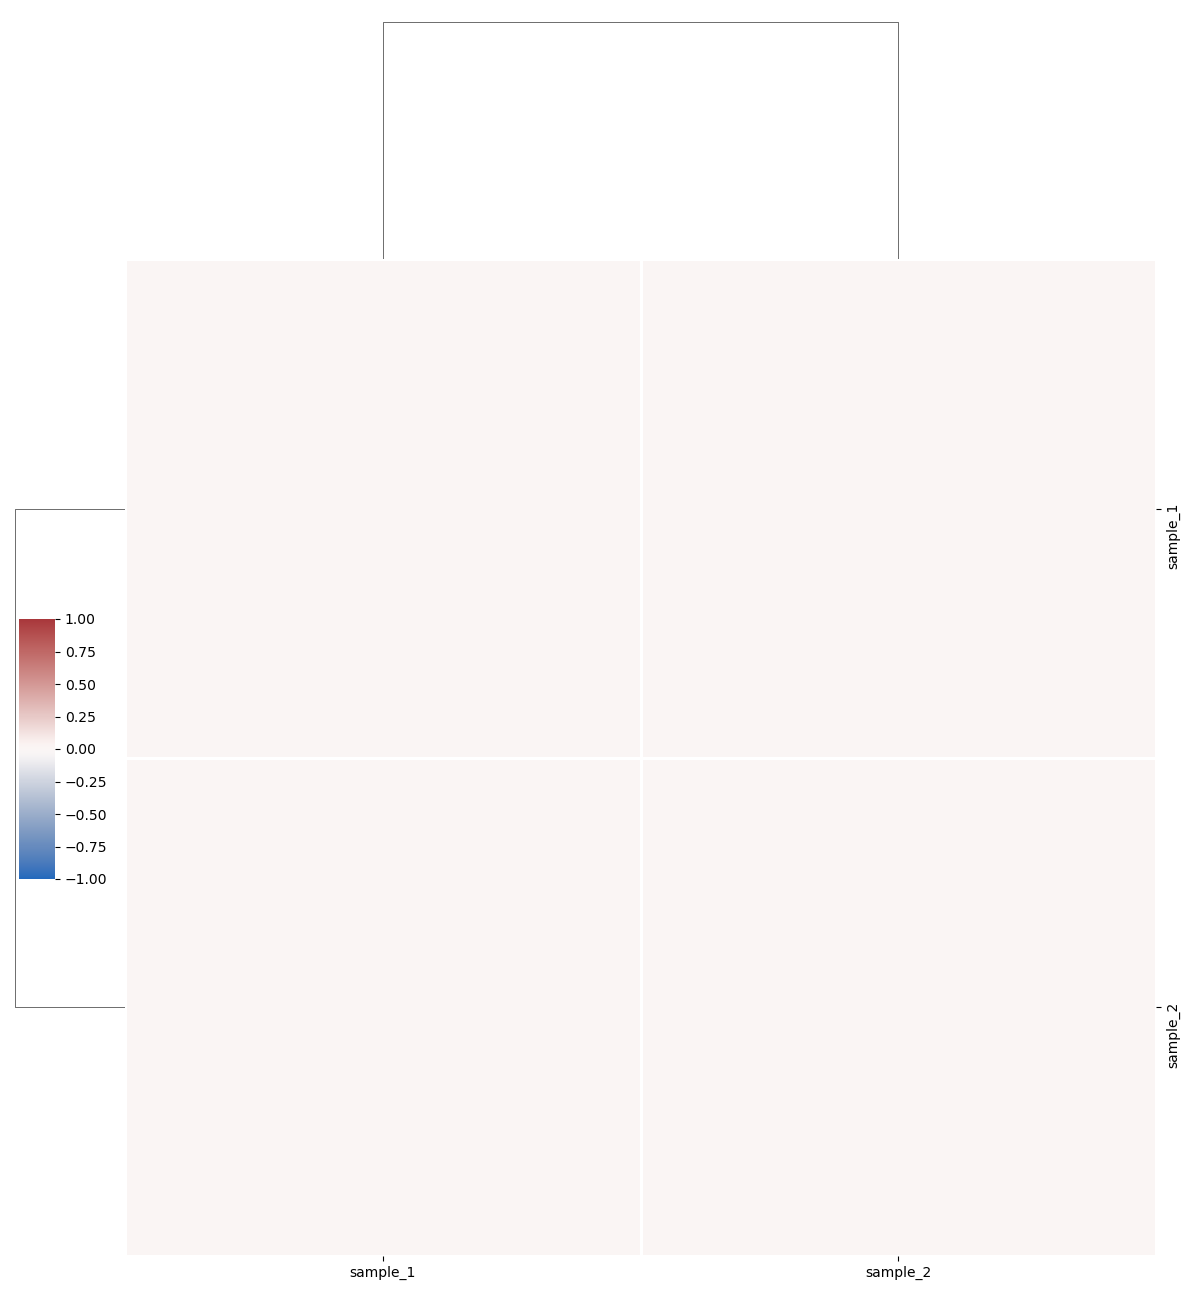

In [5]:
plot_heatmap.run(normalize=True)

INFO - Loaded 2 files
/opt/miniconda3/envs/tcrpeg_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/opt/miniconda3/envs/tcrpeg_env/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


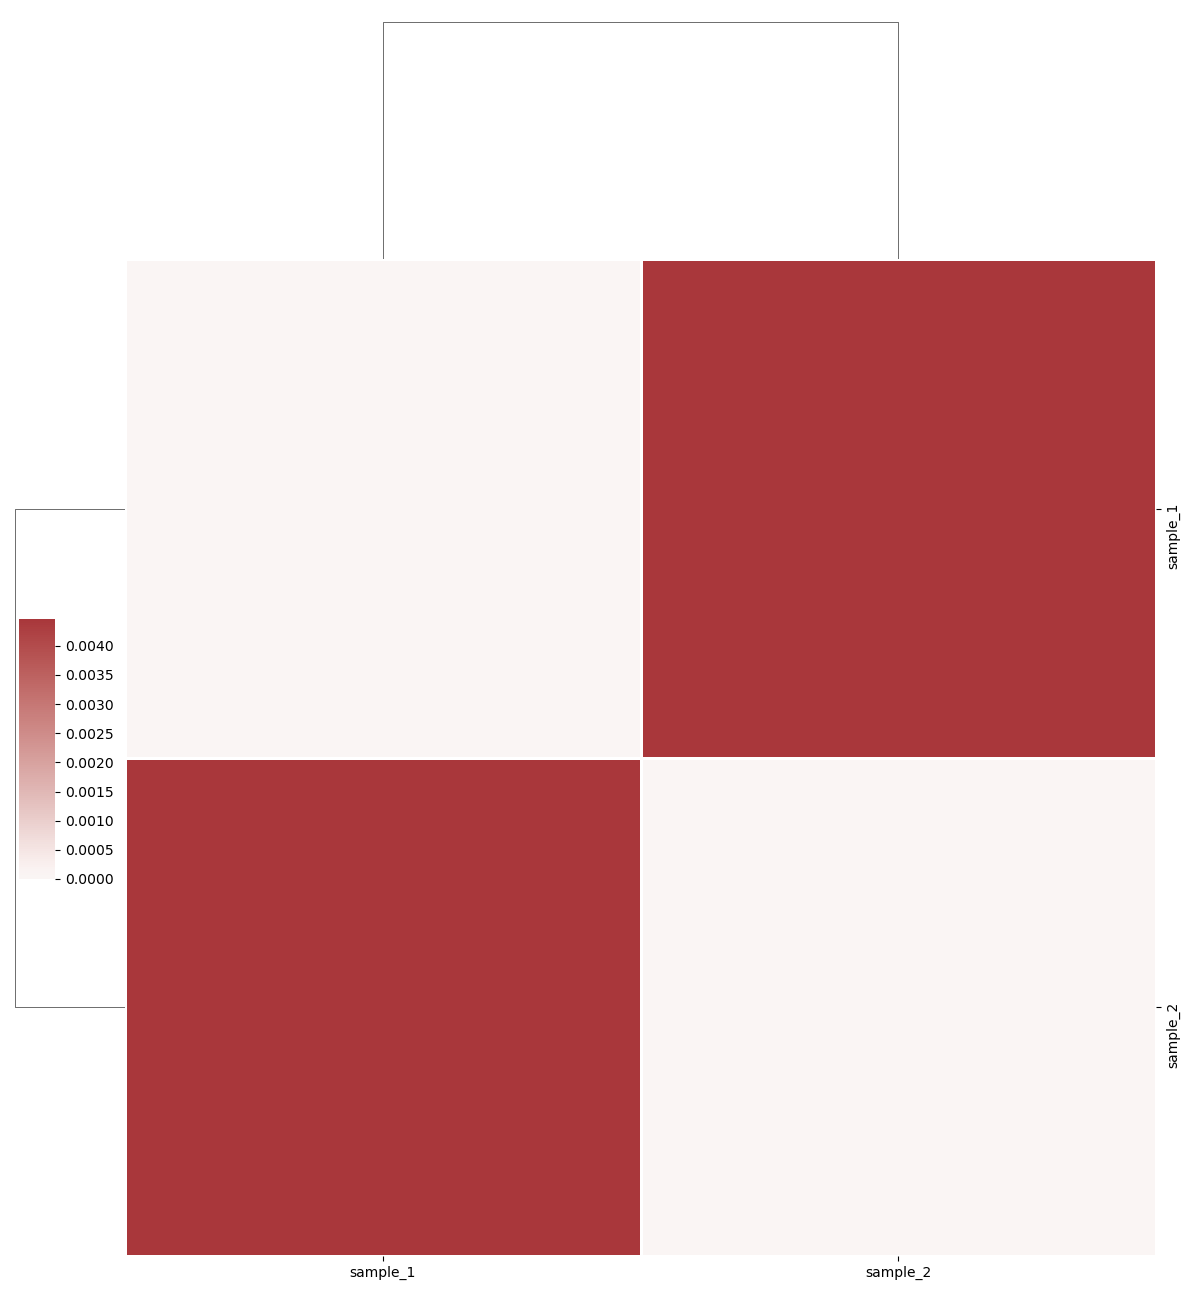

In [6]:
plot_heatmap.run()

In [6]:
plot_heatmap_metadata = PlotHeatmapPinfer(data='results_sample_data/p_infer/raw/', metadata='sample_data/metadata/metadata.csv')

INFO - Loading data...
INFO - Data loaded from sample_data/metadata/metadata.csv


INFO - Loaded 2 files


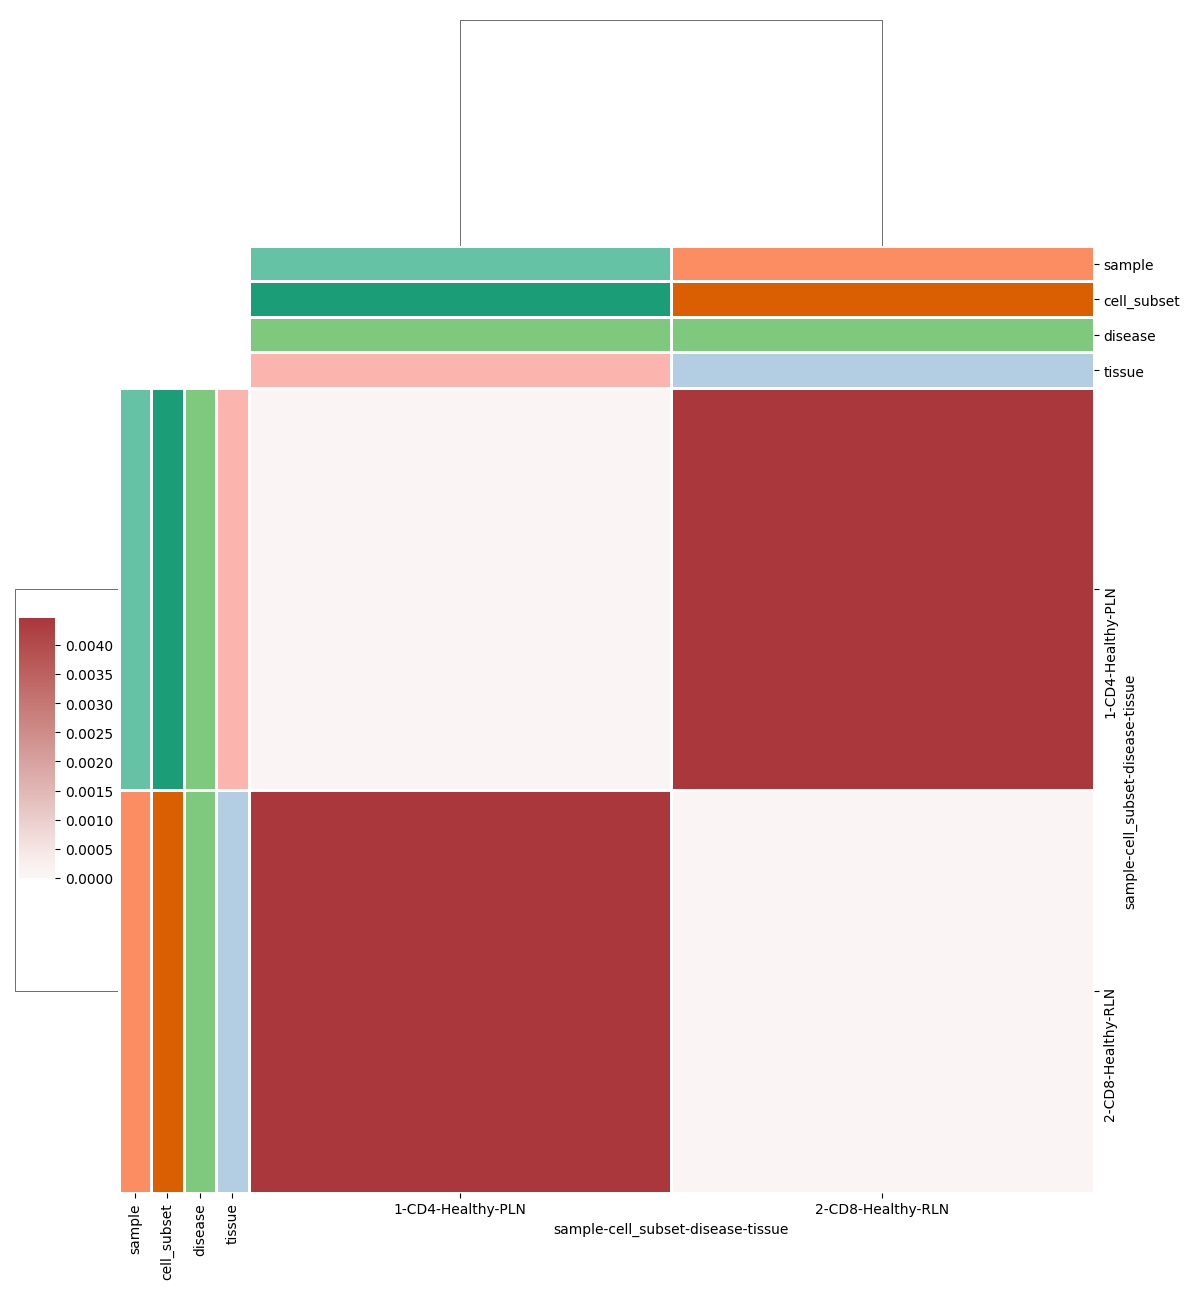

In [7]:
plot_heatmap_metadata.run()

### Debugging

In [8]:
p_infer_dict = plot_heatmap_metadata.load_data_numpy(plot_heatmap_metadata.data)

INFO - Loaded 2 files


In [9]:
distance_matrix = plot_heatmap_metadata.calculate_distance(p_infer_dict)

In [10]:
metadata_multi_idx = plot_heatmap_metadata.create_multi_index(plot_heatmap_metadata.metadata)

In [11]:
metadata_multi_idx

MultiIndex([(1, 'CD4', 'Healthy', 'PLN'),
            (2, 'CD8', 'Healthy', 'RLN')],
           names=['sample', 'cell_subset', 'disease', 'tissue'])

In [12]:
distance_matrix_annotated = plot_heatmap_metadata.annotate_distance_matrix(distance_matrix, metadata_multi_idx)

In [13]:
distance_matrix_annotated

,,,sample,1,2
,,,cell_subset,CD4,CD8
,,,disease,Healthy,Healthy
,,,tissue,PLN,RLN
sample,cell_subset,disease,tissue,,
1,CD4,Healthy,PLN,0.00000,0.00446
2,CD8,Healthy,RLN,0.00446,0.00000


In [14]:
metadata_multi_idx_colors = plot_heatmap_metadata.assign_metadata_color(metadata_multi_idx) if metadata_multi_idx is not None else None

In [15]:
metadata_multi_idx_colors

,,,,sample,cell_subset,disease,tissue
sample,cell_subset,disease,tissue,,,,
1,CD4,Healthy,PLN,"(0.4, 0.7607843137254902, 0.6470588235294118)","(0.10588235294117647, 0.6196078431372549, 0.46...","(0.4980392156862745, 0.788235294117647, 0.4980...","(0.984313725490196, 0.7058823529411765, 0.6823..."
2,CD8,Healthy,RLN,"(0.9882352941176471, 0.5529411764705883, 0.384...","(0.8509803921568627, 0.37254901960784315, 0.00...","(0.4980392156862745, 0.788235294117647, 0.4980...","(0.7019607843137254, 0.803921568627451, 0.8901..."


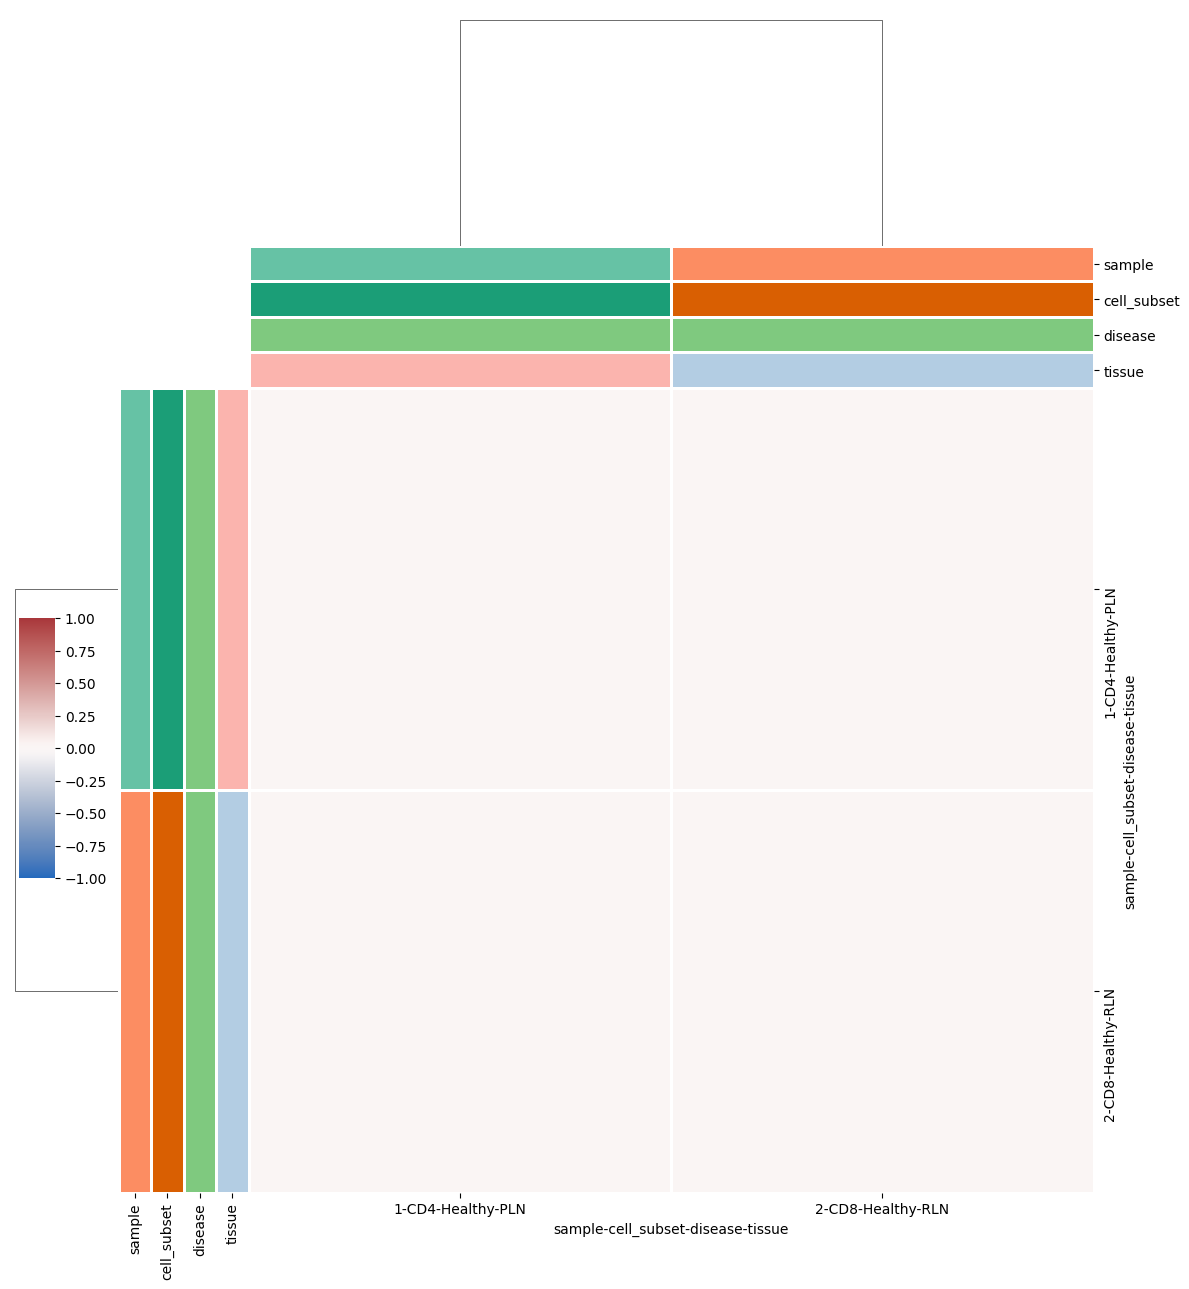

In [16]:
plot_heatmap_metadata.plot_heatmap(distance_matrix_annotated, row_colors=metadata_multi_idx_colors, col_colors=metadata_multi_idx_colors, normalize=True)

### Using the second class 

In [21]:

def process_numpy_files(folder_path, use_structured_array=True):
    data_list = []
    sample_ids = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            sample_name = os.path.splitext(file_name)[0]
            data_list.append(np.load(file_path))
            sample_ids.append(sample_name)
            
    
    if use_structured_array:
        dtype = [('sample_id', 'U50'), ('probabilities', float, (len(data_list[0]),))]
        structured_array = np.array(list(zip(sample_ids, data_list)), dtype=dtype)
        return structured_array
    else:
        return np.array(data_list), np.array(sample_ids)


In [23]:
import os
import glob
import logging
import numpy as np
import pandas as pd
from scipy.spatial.distance import jensenshannon as jsd
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt


In [29]:
def extract_probabilities(npy_file, slot_name='p_infer', message=False):
    data = np.load(npy_file)
    if data.dtype.names is not None:
        logging.info("Loaded structured array with names.") if message else None
        return data[slot_name] if slot_name in data.dtype.names else None
    else:
        logging.info("Loaded regular array.") if message else None
        return data

In [33]:
def process_numpy_files(folder_path):
    data_list = []
    sample_ids = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            sample_name = os.path.splitext(file_name)[0]
            data_list.append(extract_probabilities(file_path))
            sample_ids.append(sample_name)

    logging.info(f"Loaded {len(data_list)} files")


In [37]:
def process_numpy_files(folder_path):
    data_list = []
    sample_ids = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.npy'):
            file_path = os.path.join(folder_path, file_name)
            sample_name = os.path.splitext(file_name)[0]
            data_list.append(extract_probabilities(file_path))
            sample_ids.append(sample_name)

    logging.info(f"Loaded {len(data_list)} files")

    return data_list, sample_ids


In [40]:
p_infer, sample_name = process_numpy_files('results_sample_data/p_infer/raw/')

INFO - Loaded 2 files


In [45]:
def apply_smoothing_normalization(distributions, epsilon=1e-6):
        smoothed = [np.clip(dist + epsilon, a_min=epsilon, a_max=None) for dist in distributions]
        distributions = [dist / dist.sum() for dist in smoothed]

In [56]:
p_infer

[array([3.79878794e-04, 9.71871632e-07, 1.10055249e-06, 3.30739962e-05,
        7.28957648e-05, 1.53095453e-04, 1.71773671e-04, 8.00286218e-04,
        4.77706601e-05, 2.64538085e-06, 1.60490609e-09, 6.58928412e-03,
        3.70316148e-07, 5.96414808e-04, 2.73473058e-07, 4.96319827e-04,
        2.27855549e-03, 4.35773947e-05, 2.72978111e-06, 1.48375579e-04,
        3.15690289e-07, 1.33570750e-07, 2.60360845e-02, 4.22036861e-03,
        9.27574680e-08, 7.18522184e-04, 1.31801242e-07, 5.70518428e-10,
        5.73449935e-06, 6.81904734e-03, 2.54323112e-07, 1.74760324e-02,
        5.45495634e-05, 1.17863810e-04, 1.22351441e-06, 3.78153718e-05,
        1.09983842e-07, 8.45231579e-05, 5.24709829e-06, 1.10548447e-05,
        2.27849680e-05, 1.32053949e-06, 9.62177772e-06, 1.14719959e-06,
        1.35206285e-04, 4.29941889e-05, 5.82445499e-04, 5.92438278e-09,
        6.32792934e-06, 1.61999073e-06, 1.37738418e-04, 2.05432205e-07,
        1.00719033e-02, 1.05715225e-06, 4.40707011e-06, 1.259674

In [58]:
s = [np.clip(dist + epsilon, a_min=epsilon, a_max=None) for dist in p_infer]

In [59]:
[dist / dist.sum() for dist in s]

[array([3.80809487e-04, 1.97151282e-06, 2.10017026e-06, 3.40677959e-05,
        7.38823182e-05, 1.54067413e-04, 1.72742232e-04, 8.01140410e-04,
        4.87617854e-05, 3.64471752e-06, 1.00142265e-06, 6.58908491e-03,
        1.37006680e-06, 5.97306098e-04, 1.27324133e-06, 4.97229331e-04,
        2.27914068e-03, 4.45692831e-05, 3.72910241e-06, 1.49348397e-04,
        1.31545088e-06, 1.13336448e-06, 2.60323466e-02, 4.22060046e-03,
        1.09255862e-06, 7.19391255e-04, 1.13159529e-06, 1.00038845e-06,
        6.73327389e-06, 6.81880632e-03, 1.25409487e-06, 1.74738521e-02,
        5.55394552e-05, 1.18842180e-04, 2.22310981e-06, 3.88083087e-05,
        1.10978186e-06, 8.55075955e-05, 6.24596153e-06, 1.20526512e-05,
        2.37806399e-05, 2.32011723e-06, 1.06198449e-05, 2.14680887e-06,
        1.36181500e-04, 4.39861834e-05, 5.83339331e-04, 1.00574134e-06,
        7.32659589e-06, 2.61951398e-06, 1.38713172e-04, 1.20521286e-06,
        1.00710703e-02, 2.05677791e-06, 5.40608620e-06, 1.269443

In [48]:
distribution_one = p_infer[0]

In [54]:
epsilon=1e-50

In [52]:
np.clip(distribution_one + epsilon, a_min=epsilon, a_max=None)

array([3.80878794e-04, 1.97187163e-06, 2.10055249e-06, 3.40739962e-05,
       7.38957648e-05, 1.54095453e-04, 1.72773671e-04, 8.01286218e-04,
       4.87706601e-05, 3.64538085e-06, 1.00160491e-06, 6.59028412e-03,
       1.37031615e-06, 5.97414808e-04, 1.27347306e-06, 4.97319827e-04,
       2.27955549e-03, 4.45773947e-05, 3.72978111e-06, 1.49375579e-04,
       1.31569029e-06, 1.13357075e-06, 2.60370845e-02, 4.22136861e-03,
       1.09275747e-06, 7.19522184e-04, 1.13180124e-06, 1.00057052e-06,
       6.73449935e-06, 6.82004734e-03, 1.25432311e-06, 1.74770324e-02,
       5.55495634e-05, 1.18863810e-04, 2.22351441e-06, 3.88153718e-05,
       1.10998384e-06, 8.55231579e-05, 6.24709829e-06, 1.20548447e-05,
       2.37849680e-05, 2.32053949e-06, 1.06217777e-05, 2.14719959e-06,
       1.36206285e-04, 4.39941889e-05, 5.83445499e-04, 1.00592438e-06,
       7.32792934e-06, 2.61999073e-06, 1.38738418e-04, 1.20543221e-06,
       1.00729033e-02, 2.05715225e-06, 5.40707011e-06, 1.26967487e-04,
      

In [57]:
import numpy as np

# Example probability distribution with a zero
distribution = np.array([0.2, 0.5, 0.3, 0.0])

# Smoothing parameter
epsilon = 1e-6

# Apply smoothing
smoothed_distribution = distribution + epsilon

# Normalize to ensure it sums to 1
smoothed_distribution /= smoothed_distribution.sum()

print("Original Distribution:", distribution)
print("Smoothed Distribution:", smoothed_distribution)


Original Distribution: [0.2 0.5 0.3 0. ]
Smoothed Distribution: [2.000002e-01 4.999990e-01 2.999998e-01 9.999960e-07]


In [63]:
import matplotlib.pyplot as plt

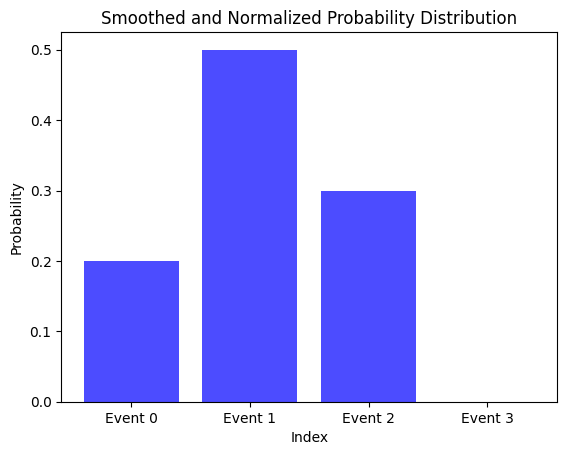

In [64]:
# Create a bar plot
plt.bar(range(len(smoothed_distribution)), smoothed_distribution, color='blue', alpha=0.7)
plt.title('Smoothed and Normalized Probability Distribution')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.xticks(range(len(smoothed_distribution)), labels=[f'Event {i}' for i in range(len(smoothed_distribution))])
plt.show()

In [69]:
import numpy as np

# Parameters for the normal distribution
mean = 0  # mean
std_dev = 1  # standard deviation
num_points = 1000  # number of data points

# Generate normally distributed data
data = np.random.normal(mean, std_dev, num_points)


In [67]:
data = distribution_one

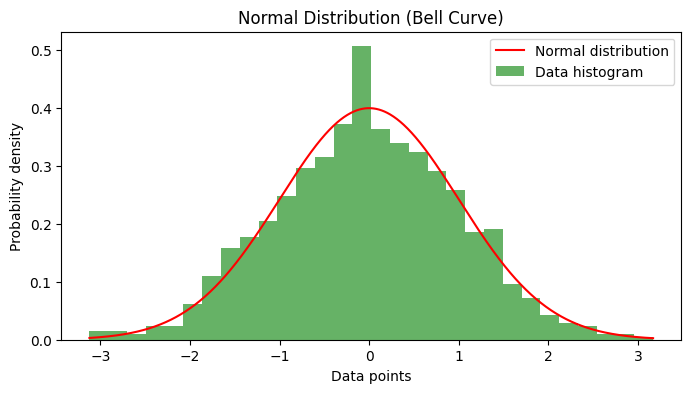

In [70]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Calculate the normal distribution's PDF (Probability Density Function)
x = np.linspace(min(data), max(data), num_points)
y = norm.pdf(x, mean, std_dev)

# Plotting the bell curve
plt.figure(figsize=(8, 4))
plt.plot(x, y, 'r-', label='Normal distribution')
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Data histogram')
plt.title('Normal Distribution (Bell Curve)')
plt.xlabel('Data points')
plt.ylabel('Probability density')
plt.legend()
plt.show()


In [71]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# Define the distributions
dist1 = np.array([0.1, 0.2, 0.3, 0.1, 0.3])  # Longer distribution
dist2 = np.array([0.1, 0.2, 0.4])            # Shorter distribution

# Case 1: Without Padding
# Truncate dist1 to the length of dist2 for a fair comparison
dist1_truncated = dist1[:len(dist2)]
jsd_without_padding = jensenshannon(dist1_truncated, dist2, base=2)

# Case 2: Padding with Zero
target_length = len(dist1)
dist2_padded_zero = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(0,))
jsd_zero_padded = jensenshannon(dist1, dist2_padded_zero, base=2)

# Case 3: Padding with Epsilon
epsilon = 1e-6
dist2_padded_epsilon = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(epsilon,))
dist1_normalized = dist1 + epsilon  # Adding epsilon to all elements of dist1 as well
dist2_normalized = dist2_padded_epsilon + epsilon

# Normalize distributions to ensure they sum to 1
dist1_normalized /= dist1_normalized.sum()
dist2_normalized /= dist2_normalized.sum()

jsd_epsilon_padded = jensenshannon(dist1_normalized, dist2_normalized, base=2)

print("Jensen-Shannon Divergence without padding:", jsd_without_padding)
print("Jensen-Shannon Divergence with zero padding:", jsd_zero_padded)
print("Jensen-Shannon Divergence with epsilon padding:", jsd_epsilon_padded)


Jensen-Shannon Divergence without padding: 0.0608477735158521
Jensen-Shannon Divergence with zero padding: 0.4891136545438643
Jensen-Shannon Divergence with epsilon padding: 0.48906499409822396


In [72]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# Define the distributions
dist1 = np.array([0.1, 0.2, 0.3, 0.1, 0.3])  # Longer distribution
dist2 = np.array([0.1, 0.2, 0.4])            # Shorter distribution

# Epsilon for padding
epsilon = 1e-6
target_length = len(dist1)

# Padding with Epsilon
dist2_padded_epsilon = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(epsilon,))

# Case 1: Epsilon Padding without Smoothing
dist1_with_epsilon = dist1 + epsilon
jsd_epsilon_padded_without_smoothing = jensenshannon(dist1_with_epsilon, dist2_padded_epsilon, base=2)

# Case 2: Epsilon Padding with Smoothing
# Adding epsilon to all elements and then normalizing
dist1_normalized = dist1 + epsilon
dist2_normalized = dist2_padded_epsilon + epsilon
dist1_normalized /= dist1_normalized.sum()
dist2_normalized /= dist2_normalized.sum()

jsd_epsilon_padded_with_smoothing = jensenshannon(dist1_normalized, dist2_normalized, base=2)

print("Jensen-Shannon Divergence with epsilon padding (without smoothing):", jsd_epsilon_padded_without_smoothing)
print("Jensen-Shannon Divergence with epsilon padding (with smoothing):", jsd_epsilon_padded_with_smoothing)


Jensen-Shannon Divergence with epsilon padding (without smoothing): 0.48908793822094176
Jensen-Shannon Divergence with epsilon padding (with smoothing): 0.48906499409822396


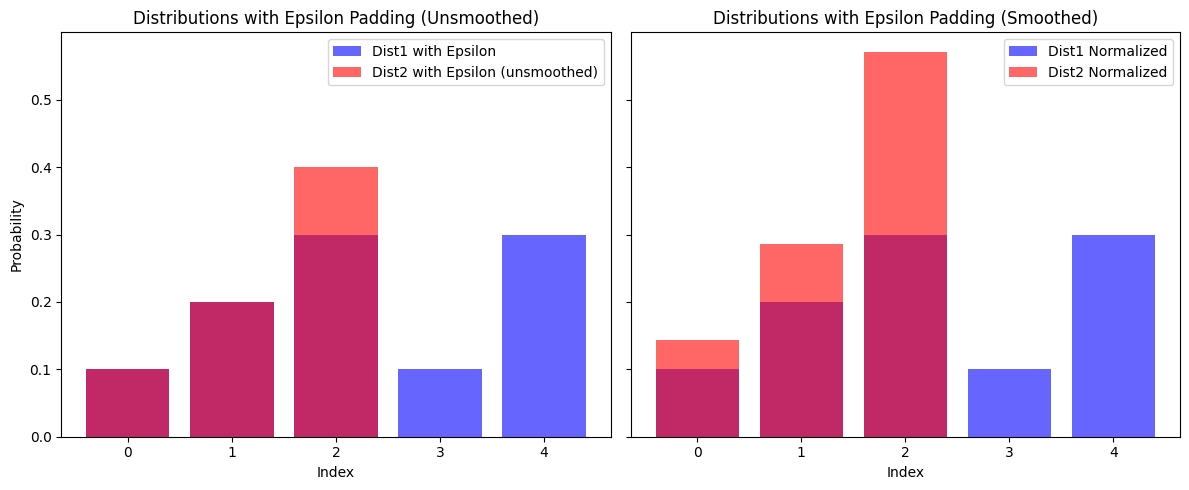

In [73]:
import numpy as np
import matplotlib.pyplot as plt

# Define the distributions
dist1 = np.array([0.1, 0.2, 0.3, 0.1, 0.3])  # Longer distribution
dist2 = np.array([0.1, 0.2, 0.4])            # Shorter distribution

# Epsilon for padding
epsilon = 1e-6
target_length = len(dist1)

# Padding with Epsilon
dist2_padded_epsilon = np.pad(dist2, (0, target_length - len(dist2)), 'constant', constant_values=(epsilon,))

# Distributions after padding with epsilon but without smoothing
dist1_with_epsilon = dist1 + epsilon
dist2_with_epsilon = dist2_padded_epsilon

# Normalizing the distributions
dist1_normalized = dist1_with_epsilon / dist1_with_epsilon.sum()
dist2_normalized = dist2_with_epsilon / dist2_with_epsilon.sum()

# Creating the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Without Smoothing
ax1.bar(range(len(dist1_with_epsilon)), dist1_with_epsilon, alpha=0.6, label='Dist1 with Epsilon', color='blue')
ax1.bar(range(len(dist2_with_epsilon)), dist2_with_epsilon, alpha=0.6, label='Dist2 with Epsilon (unsmoothed)', color='red')
ax1.set_title('Distributions with Epsilon Padding (Unsmoothed)')
ax1.set_xlabel('Index')
ax1.set_ylabel('Probability')
ax1.legend()

# With Smoothing
ax2.bar(range(len(dist1_normalized)), dist1_normalized, alpha=0.6, label='Dist1 Normalized', color='blue')
ax2.bar(range(len(dist2_normalized)), dist2_normalized, alpha=0.6, label='Dist2 Normalized', color='red')
ax2.set_title('Distributions with Epsilon Padding (Smoothed)')
ax2.set_xlabel('Index')
ax2.legend()

plt.tight_layout()
plt.show()


In [75]:
import numpy as np

def pad_and_normalize_distributions(distributions, epsilon=1e-6):
    # Determine the maximum length of any distribution in the list
    max_length = max(len(dist) for dist in distributions)

    # Pad all distributions to this maximum length with epsilon
    padded_distributions = [
        np.pad(dist, (0, max_length - len(dist)), 'constant', constant_values=(epsilon,))
        for dist in distributions
    ]

    # Normalize each distribution to ensure it sums to 1
    normalized_distributions = [
        dist / dist.sum() for dist in padded_distributions
    ]

    return normalized_distributions

# Example usage
distributions = [np.array([0.1, 0.2, 0.3]), np.array([0.1, 0.2]), np.array([0.3])]
normalized_distributions = pad_and_normalize_distributions(distributions)

# Now you can calculate the distance matrix using these normalized distributions


In [91]:
normalized_p_infer = pad_and_normalize_distributions(p_infer, epsilon=1e-20)

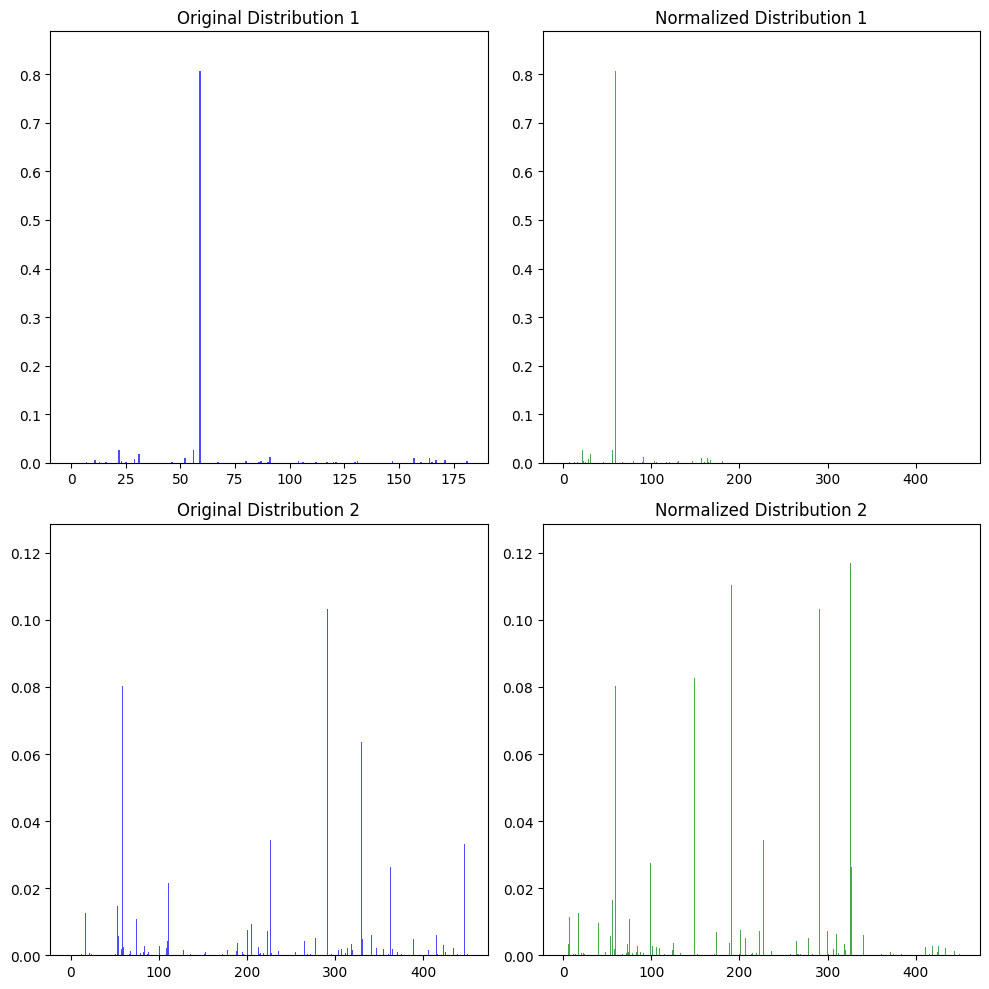

In [92]:
# Plotting
fig, axes = plt.subplots(nrows=len(p_infer), ncols=2, figsize=(10, 5 * len(p_infer)))

for i in range(len(p_infer)):
    # Original p_infer with padding visualized
    axes[i, 0].bar(range(len(p_infer[i])), p_infer[i], color='blue', alpha=0.7)
    axes[i, 0].set_title(f'Original Distribution {i+1}')
    axes[i, 0].set_ylim(0, 1.1 * max(p_infer[i]))
    
    # Normalized p_infer
    axes[i, 1].bar(range(len(normalized_p_infer[i])), normalized_p_infer[i], color='green', alpha=0.7)
    axes[i, 1].set_title(f'Normalized Distribution {i+1}')
    axes[i, 1].set_ylim(0, 1.1 * max(normalized_p_infer[i]))

# Add some spacing between plots
plt.tight_layout()
plt.show()

In [93]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import entropy

def jensen_shannon_divergence(p, q):
    m = 0.5 * (p + q)
    return 0.5 * (entropy(p, m) + entropy(q, m))


In [97]:

# Calculate the pairwise JSD matrix
distance_matrix = squareform(pdist(normalized_p_infer, metric=lambda u, v: jensen_shannon_divergence(u, v)))

print("Distance Matrix:\n", distance_matrix)


Distance Matrix:
 [[0.         0.53081797]
 [0.53081797 0.        ]]


In [98]:
from scipy.spatial.distance import jensenshannon as jsd

In [99]:

# Calculate the pairwise JSD matrix
distance_matrix_2 = squareform(pdist(normalized_p_infer, metric=lambda u, v: jsd(u, v)**2))

print("Distance Matrix:\n", distance_matrix_2)


Distance Matrix:
 [[0.         0.53081797]
 [0.53081797 0.        ]]


In [100]:
from scipy.stats import wasserstein_distance

# Calculate the pairwise JSD matrix
distance_matrix_2 = squareform(pdist(normalized_p_infer, metric=lambda u, v: wasserstein_distance(u, v)))

print("Distance Matrix:\n", distance_matrix_2)

Distance Matrix:
 [[0.         0.00306301]
 [0.00306301 0.        ]]


In [103]:
wasserstein_distance(normalized_p_infer[0], normalized_p_infer[1])

0.00306301209189235

In [104]:
wasserstein_distance(p_infer[0], p_infer[1])

0.004459688163589489

In [101]:
squareform(pdist(normalized_p_infer, metric='jensenshannon'))

array([[0.        , 0.72857256],
       [0.72857256, 0.        ]])

In [121]:
class DistributionAnalysis:
    def __init__(self, data):
        self.data = data
        self.distributions = []
        self.ids = []
        self.distance_matrix = None
        self.load_distributions()

    def load_distributions(self):
        if self.data is None:
            raise ValueError("No data provided. Load data first.")
        if not all(hasattr(self.data, attr) for attr in ['distributions', 'ids']):
            self.data = DistributionLoader(self.data)
        self.distributions = self.data.distributions
        self.ids = self.data.ids

In [128]:
class DistributionLoader:
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.distributions = []
        self.sample_ids = []
        self.load_distributions()

    def load_distributions(self, slot_name='p_infer', message=False):
        files = [f for f in os.listdir(self.folder_path) if f.endswith('.npy')]
        self.distributions = []
        self.ids = []

        for file_name in files:
            file_path = os.path.join(self.folder_path, file_name)
            data = np.load(file_path)

            if data.dtype.names is not None:
                # Extract a specific slot if it's a structured array
                if slot_name in data.dtype.names:
                    distribution = data[slot_name]
                else:
                    distribution = None  # or handle the absence of the slot differently
                logging.info(f"Loaded structured array with names from {file_name}") if message else None
            else:
                # Handle regular array
                distribution = data
                logging.info(f"Loaded regular array from {file_name}") if message else None

            # Append the loaded data and sample ID
            if distribution is not None:
                self.distributions.append(distribution)
                sample_name = os.path.splitext(file_name)[0].split(f'_{slot_name}')[0]
                self.ids.append(sample_name)

        logging.info(f"Loaded {len(self.distributions)} distributions with their IDs")

    def __repr__(self):
        return f"DistributionLoader(distributions={len(self.distributions)}, folder_path={self.folder_path})"


In [131]:
data = DistributionLoader('results_sample_data/p_infer/structured/')

INFO - Loaded 2 distributions with their IDs


In [126]:
data

DistributionLoader(folder_path=results_sample_data/p_infer/raw/), distributions=2

In [133]:
from tcrpeg_toolkit.p_infer_distribution_analyzer import DistributionLoader, DistributionAnalyzer

In [135]:
rmp = DistributionLoader('results_sample_data/p_infer/structured/')

INFO - Loaded 2 distributions with their IDs


In [ ]:
DistributionAnalyzer('results_sample_data/p_infer/structured/')

INFO - Loaded 2 distributions with their IDs


DistributionAnalyzer(distributions=2, ids=2)

In [142]:
samples = DistributionAnalyzer('results_sample_data/p_infer/structured/')

INFO - Loaded 2 distributions with their IDs


In [143]:
samples

DistributionAnalyzer(distributions=2, ids=2)

In [145]:
samples.pad_and_normalize_distributions()

In [149]:
dist = samples.calculate_distance_matrix()
dist

array([[0.       , 0.5302668],
       [0.5302668, 0.       ]])

In [160]:
dist = samples.calculate_distance_matrix(metric='wd')
dist

INFO - Wasserstein distance metric selected.


array([[0.        , 0.00306227],
       [0.00306227, 0.        ]])

In [162]:
distance_matrix_annotated

,,,sample,1,2
,,,cell_subset,CD4,CD8
,,,disease,Healthy,Healthy
,,,tissue,PLN,RLN
sample,cell_subset,disease,tissue,,
1,CD4,Healthy,PLN,0.00000,0.00446
2,CD8,Healthy,RLN,0.00446,0.00000


In [170]:
dist_df = pd.DataFrame(dist, index=samples.ids, columns=samples.ids)

In [171]:
dist_df

,sample_2_structured,sample_1_structured
sample_2_structured,0.000000,0.003062
sample_1_structured,0.003062,0.000000


In [4]:
from tcrpeg_toolkit.distribution_handler import DistributionTransformer, DistributionHeatmapPlotter 

In [5]:
dist_distribution = Distribution(distributions=samples.distributions, ids=samples.ids, distance_matrix=dist)

NameError: name 'samples' is not defined

In [193]:
dist_heatmap = DistributionHeatmapPlotter(dist_distribution)

In [196]:
dist_heatmap

AttributeError: 'DistributionHeatmapPlotter' object has no attribute 'distributions'